In [154]:
import subprocess
from multiprocessing import Pool
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import spline
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
#import statsmodels.api as smdl
%run averaging.ipynb
%run optimize_slope.ipynb

In [2]:
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

In [3]:
def write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True):
    ftext = """sprintf(my_seed,"%05g",SEED)

    iterations = e3

    INCLUDE_FILE = "../outputLoc.mdl"
    INCLUDE_FILE = "../initialization.mdl"
    INCLUDE_FILE = "parameters.mdl"
    /* Modifications in Parameters */
        VDCC_number_presynaptic = 40

        n_Glu_neuron =  1 //2000
        GluT_density_astrocyte = 0.1 //1000

        ca_conc_presynaptic_er = e-6     //initial ER conc specified here!!!!!
        //ryr_number_presynaptic = 0 //no RYR

    f =                                 //SERCA parameter adjustments here!!!!!!!!!!

    sm = //multiply all serca parameters

    /*Initial SERCA fractions*/
    serca_x1_feq = 
    serca_x1a_feq = 
    serca_x2_feq = 
    serca_y1_feq = 
    serca_y1a_feq = 
    serca_y2_feq = 

    INCLUDE_FILE = "rxn_rate_constants.mdl"
    /* Modifications in Reaction Rate Constants */
    //k_PMCA_0_1 = 0
    //k_PMCA_0_leak = 0


    /* Output Folder */
            //isi = "40"
        sprintf(VDCC, "%g", VDCC_number_presynaptic)
        sprintf(f_mult, "%g", f) 
        sprintf(s_mult, "%g", sm) 
        sprintf(init_er_conc, "%g", ca_conc_presynaptic_er*1e6)   	
        fname = 

        output_folder = outputLoc & "ppf/" & fname & "/sm" & s_mult & "/" & f_mult & "/" & init_er_conc & "/s_" & my_seed

    /* Rates for P/Q-type Voltage Dependent Calcium Channels */
    /* From Bischoffberger et al., 2005, , Biophys. J.*/

        k_VDCC_PQ_C01 = 0
        k_VDCC_PQ_C12 = 0
        k_VDCC_PQ_C23 = 0
        k_VDCC_PQ_C34 = 0
        k_VDCC_PQ_C43 = 0
        k_VDCC_PQ_C32 = 0
        k_VDCC_PQ_C21= 0
        k_VDCC_PQ_C10 = 0
        k_VDCC_PQ_Ca = 0

    INCLUDE_FILE = "triggered_release.inc.mdl"

    INCLUDE_FILE = "rxn_outputRS.mdl"
    //INCLUDE_FILE = "viz_output.mdl"
    """
    ftext=ftext.replace('iterations = ', 'iterations = '+str(iterations))
    ftext=ftext.replace('sm = ', 'sm = '+str(sm))
    ftext=ftext.replace('ca_conc_presynaptic_er = ', 'ca_conc_presynaptic_er = '+str(ic))
    ftext=ftext.replace('f = ','f = '+str(sf))
    ftext=ftext.replace('fname = ','fname = '+'"'+str(outfolder)+'"')
    for i,p in enumerate(['x1','x1a','x2','y2','y1a','y1']):
        old="serca_"+p+"_feq = "
        new="serca_"+p+"_feq = "+str(serca_frac[i])
        ftext=ftext.replace(old,new)
    if write:
        with open(file_name,'w') as wfile:
            wfile.write(ftext)

            

In [140]:
%run get_SERCA_equilibrium.ipynb
#checking refilling times for 500 sf=2
final_conc=500
sf=2
initial_conc=[100,300,400,450,477,490,495]
serca_mult=[3,6,9,12,15]

folder="/home/kabir/Project/tripartiteSynapse/brute750_8/"
outfolder="brute9"


iterations=5000
fnames=[]

for sm in serca_mult:
    for ic in initial_conc:
        serca_frac=get_SERCA_equilibrium(ic)
        file_name=folder+"RSnostim_sm"+str(sm)+"_ic"+str(ic)+"_fc"+str(final_conc)+".mdl"
        fnames.append(file_name)
        write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True)
        

In [145]:
%run get_SERCA_equilibrium.ipynb
#checking refilling times for 500 sf=2
final_conc=500
sf=2
initial_conc=[0]
serca_mult=[70,100,150]

folder="/home/kabir/Project/tripartiteSynapse/brute750_8/"
outfolder="brute9"


iterations=20000
fnames=[]

for sm in serca_mult:
    for ic in initial_conc:
        serca_frac=[1,0,0,0,0,0]
        file_name=folder+"RSnostim_sm"+str(sm)+"_ic"+str(ic)+"_fc"+str(final_conc)+"long.mdl"
        fnames.append(file_name)
        write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True)

In [25]:
%run get_SERCA_equilibrium.ipynb
#checking refilling times for 500 sf=2
final_conc=500
sf=2
initial_conc=[100,300,450,475,490,500]
serca_mult=[100,300,500,700]

folder="/home/kabir/Project/tripartiteSynapse/brute750_8/"
outfolder="brute9"


iterations=5000
fnames=[]

for sm in serca_mult:
    for ic in initial_conc:
        serca_frac=get_SERCA_equilibrium(ic)
        file_name=folder+"RSnostim_sm"+str(sm)+"_ic"+str(ic)+"_fc"+str(final_conc)+".mdl"
        fnames.append(file_name)
        write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True)
        

In [39]:
%run get_SERCA_equilibrium.ipynb
#checking refilling times for 500 sf=2, sm=70
final_conc=500
sf=2
initial_conc=[300,450,475,490]
serca_mult=[70]

folder="/home/kabir/Project/tripartiteSynapse/brute750_8/"
outfolder="brute9"


iterations=1500
fnames=[]

for sm in serca_mult:
    for ic in initial_conc:
        serca_frac=get_SERCA_equilibrium(ic)
        file_name=folder+"RSnostim_sm"+str(sm)+"_ic"+str(ic)+"_fc"+str(final_conc)+".mdl"
        fnames.append(file_name)
        write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True)
        

In [47]:
#write run.sh
with open(folder+'run.sh','w') as f:
    for name in fnames:
            #f.write("sed --i 's/^#PBS -J.*/#PBS -J 1-"+str(50)+"/' pbs.py")
            f.write("qsub -N "+name.replace('.mdl','').replace(folder+'RSnostim_','')+" -v I='"+name.replace('/kabir/Project/','/subhadra/kabir/')+"' pbs.py\n")
            f.write("\n")

In [48]:
#sync script files to cluster
p=subprocess.call(["rsync","-arhP",folder[:-1],"subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/"])

In [103]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/brute9","/data/kabir/output/ppf/"])

In [4]:
#average 500 for f
ic=500

initial_conc=[100,300,400,450,477,490,495]
serca_mult=[3,6,9,12,15]
sf=2

for sm in serca_mult:
    for ic in initial_conc:
        averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        
#load data 500
data={}
for sm in serca_mult:
    data[sm]={}
    for ic in initial_conc:
        data_file='/data/kabir/output/ppf/brute9/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/Average/ca.dat'
        #print data_file
        data[sm][ic]=np.loadtxt(data_file)
        data[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

In [125]:
#average 750 for f
ic=750

serca_mult=[3,6,9,12,15]
serca_f=[3]

#serca_mult=[1]#[3,6,9,12,15]#[1]
#serca_f=[2,2.2,2.4,2.6,2.8,2.9,3,3.1,3.2,3.4,3.6,3.8,4]

for sm in serca_mult:
    for sf in serca_f:
        averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        
#load data 750
data={}
ic=750
for sm in serca_mult:
    data[sm]={}
    for sf in serca_f:
        data_file='/data/kabir/output/ppf/brute8/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/Average/ca.dat'
        #print data_file
        data[sm][sf]=np.loadtxt(data_file)
        data[sm][sf].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar """

In [122]:
%run averaging.ipynb
#checking refilling times for 500 sf=2
final_conc=500
sf=2
initial_conc=[300,450,475,490]
serca_mult=[70]
data_locs=[]
for sm in serca_mult:
    for ic in initial_conc:
        #averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        data_locs.append("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
p=Pool(7)
data_list=p.map(averager,data_locs)
sm_len=len(serca_mult)
ic_len=len(initial_conc)

In [123]:
"""data={}
for i,sm in enumerate(serca_mult):
    data[sm]={}
    for j,ic in enumerate(initial_conc):
        #print('i=',i,'j=',j)
        #print(i*sm_len+j)
        data[sm][ic]=data_list[i*sm_len+j]
        #data[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6"""
#load data 500
data={}
for sm in serca_mult:
    data[sm]={}
    for ic in initial_conc:
        data_file='/data/kabir/output/ppf/brute9/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/Average/ca.dat'
        #print data_file
        data[sm][ic]=np.loadtxt(data_file)
        data[sm][ic].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar

Slope =  24.87530499964691  Conc =  319.07145972236697
Slope =  4.9279868925182395  Conc =  453.6343486195493
Slope =  2.129347548781608  Conc =  476.74096955806186
Slope =  1.2058793068668718  Conc =  490.97049973910384


(475, 480)

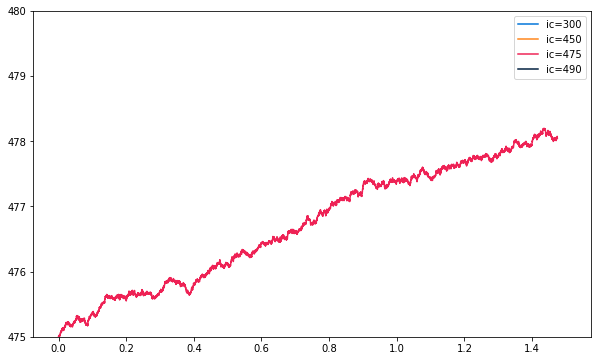

In [124]:
#plot sf=2, sm= for different ic

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sf=2
sm=70
#ic=300
more_slope_conc={'slope':[],'conc':[]}
plt.figure(figsize=(10,6))
for i,ic in enumerate(initial_conc):
    ydata=data[sm][ic].T[1]
    xdata=data[sm][ic].T[0]
    #ydata = gaussian_filter1d(ydata, sigma=300)
    plt.plot(xdata,ydata,color=color[i],label='ic='+str(ic))
    slope,conc=eval_slope_conc(0.75,xdata,ydata,0.70)
    print("Slope = ",slope," Conc = ",conc)
    more_slope_conc['slope'].append(slope)
    more_slope_conc['conc'].append(conc)

for key in more_slope_conc.keys():
    more_slope_conc[key]=np.array(more_slope_conc[key])
    
plt.legend()
plt.ylim((475,480))    
#plt.xlim((0.25,0.75))
#plt.savefig('/home/kabir/Project/plots/brute6/new_sf_750.eps')#"""
#plt.savefig('/home/kabir/Project/midsemreport_spring2019/new_sm.eps')


In [56]:
def eval_tau_at_time(t,xdata,ydata,A,range):
    tstep=xdata[1]-xdata[0]
    delta_t=range
    lower,upper=int(max(0,(t-delta_t)/tstep)),int(min(len(xdata),(t+delta_t)/tstep))
    a, b, r_value, p_value, std_err= stats.linregress(xdata[lower:upper],ydata[lower:upper])
    conc=a*t+b
    tau=(A-conc)/a
    #print('conc=',conc,'tau=',tau,'error=',std_err)
    return a,b,tau

sm= 100
sm= 300
sm= 500
sm= 700


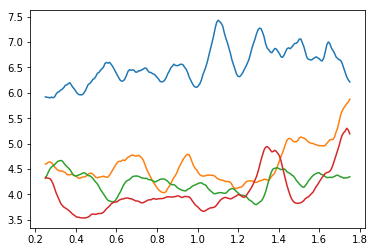

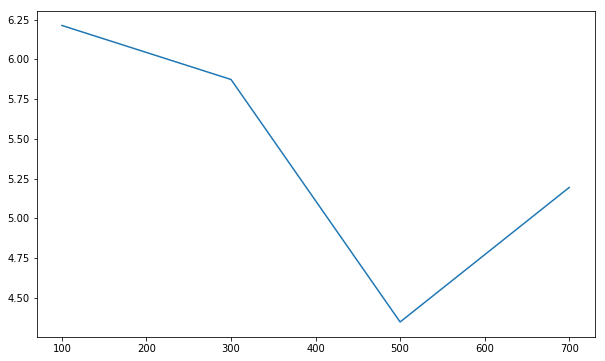

In [138]:
serca_mult=[100,300,500,700]

ic = 300
taus=[]
for sm in serca_mult:
    ydata=data[sm][ic].T[1]
    xdata=data[sm][ic].T[0]
    print('sm=',sm)
    tau_i=[]
#    eval_tau_at_time(1,xdata,ydata,500)
    for t in np.linspace(0.25,1.75,200): 
        slope,intercept,tau=eval_tau_at_time(t,xdata,ydata,500)
        tau_i.append(tau)
    plt.plot(np.linspace(0.25,1.75,200),tau_i)
    taus.append(np.average(tau))
    
plt.figure(figsize=(10,6))
plt.plot(serca_mult,taus)

In [14]:
#average,full refilling
initial_conc=[0]

serca_mult=[70,100,150]
serca_f=[2]
sf=serca_f[0]

#serca_mult=[1]#[3,6,9,12,15]#[1]
#serca_f=[2,2.2,2.4,2.6,2.8,2.9,3,3.1,3.2,3.4,3.6,3.8,4]

data_locs=[]
for sm in serca_mult:
    for ic in initial_conc:
        #averager("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
        data_locs.append("/data/kabir/output/ppf/brute9/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")
p=Pool(7)
data_list=p.map(averager,data_locs)
sm_len=len(serca_mult)
ic_len=len(initial_conc)

UnboundLocalError: local variable 'i' referenced before assignment

In [125]:
#load data, full refilling
data={}
initial_conc=[0]

serca_mult=[70,100,150]
serca_f=[2]
sf=serca_f[0]
seed={70:8,100:4,150:2}
for sm in serca_mult:
    data[sm]={}
    for ic in initial_conc:
        data_file='/data/kabir/output/ppf/brute9/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/s_0000'+str(seed[sm])+'/dat/ca.dat'
        #print data_file
        data[sm][ic]=np.loadtxt(data_file)
        data[sm][ic].T[3]*=1e15/N_avo/vol_er*1e6 #micromolar

In [51]:
def exp_fit(x,c,tau):
    A=500
    return A*(1-np.exp(-(x-c)/tau))

In [88]:
def eval_slope_conc(t,xdata,ydata,range):
    tstep=xdata[1]-xdata[0]
    delta_t=range
    lower,upper=int(max(0,(t-delta_t)/tstep)),int(min(len(xdata),(t+delta_t)/tstep))
    a, b, r_value, p_value, std_err= stats.linregress(xdata[lower:upper],ydata[lower:upper])
    conc=a*t+b

    #print('conc=',conc,'tau=',tau,'error=',std_err)
    return a,conc

a= 0.3842133105762622 
b= -65.432415126828
[ 8.56400156e-07 -1.07825697e-04  1.28255652e-01 -4.63507474e-01]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


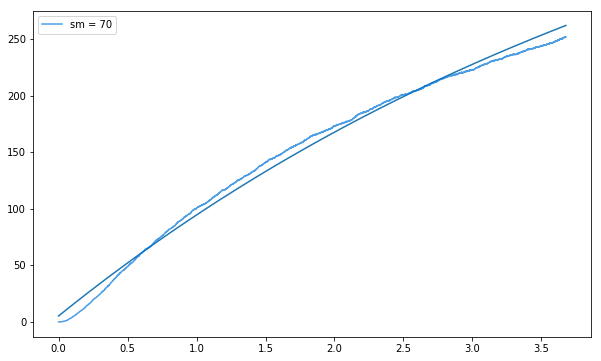

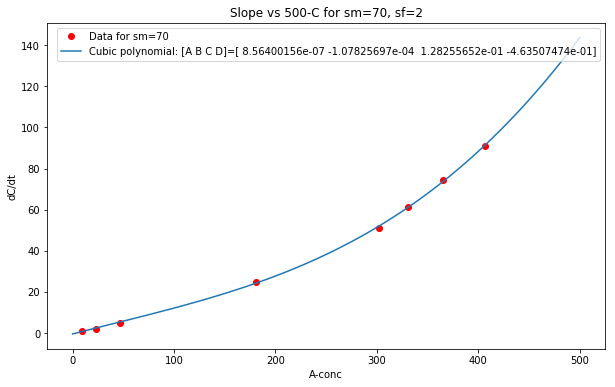

In [173]:
color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

ic=0
plt.figure(figsize=(10,6))
for i,sm in enumerate([70]):
    ydata=data[sm][ic].T[3]
    xdata=data[sm][ic].T[0]
    popt,pcov=curve_fit(exp_fit,xdata,ydata,p0=[0,5])
    plt.plot(xdata,exp_fit(xdata,*popt))
    plt.plot(xdata,ydata,color=color[i%12],label='sm = '+str(sm), alpha=0.7)
plt.legend()

plt.figure(figsize=(10,6))
for sm in [70]:
    slope_conc_data={'slope':[],'conc':[]}
    ydata=data[sm][ic].T[3]
    xdata=data[sm][ic].T[0]
    times=[1,1.5,2,2.5]
    for t in times: 
        slope,conc=eval_slope_conc(t,xdata,ydata,1)
        slope_conc_data['slope'].append(slope)
        slope_conc_data['conc'].append(conc)
    for key in slope_conc_data.keys():
        slope_conc_data[key]=np.array(slope_conc_data[key])
    xdata,ydata=500-slope_conc_data['conc'],slope_conc_data['slope']
    #plt.plot(xdata,ydata,'ro')
    a, b, r_value, p_value, std_err= stats.linregress(xdata,ydata)
    print('a=',a,'\nb=',b)
xdata=500-np.concatenate((slope_conc_data['conc'],more_slope_conc['conc']))
ydata=np.concatenate((slope_conc_data['slope'],more_slope_conc['slope']))
plt.plot(xdata,ydata,'ro',label="Data for sm=70")

def poly(x,A,B,C,D):
    return A*x**3+B*x**2+C*x+D
    #return x**A+B

popt,pcov=curve_fit(poly,xdata,ydata)
x=np.linspace(0,500,100)
y=spline(xdata, ydata, x, order=3, kind='smoothest')
plt.plot(x,poly(x,*popt),label="Cubic polynomial: [A B C D]="+str(popt))
print(popt)
#plt.xlim(())
plt.title("Slope vs 500-C for sm=70, sf=2")
plt.legend()
plt.xlabel("A-conc")
plt.ylabel("dC/dt")
plt.savefig('/home/kabir/Project/plots/brute6/slope_conc_sm70.eps')




In [ ]:
def max_file_len(data_loc):
    seed_folders=os.listdir(data_loc)
    seed_folders.remove("Average")
    print(seed_folders)
    for s in seed_folders:
        file_name=os.path.join(data_loc,os.path.join(s+'/dat/ca.dat'))
        print(s,file_len(file_name))

In [ ]:
def file_len(fname):
    i=-1
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [ ]:
max_file_len("/data/kabir/output/ppf/brute9/sm70/2/0/")

In [101]:
a= 0.3901029977136642 
b= -67.62046808120242

serca_conc_tot = 15e-6
serca_number_presynaptic=serca_conc_tot*vol_cyt/(1e15/6.02205e23)
leak_number=serca_number_presynaptic/10

ER_conc_rate=a*250+b #in micromolar per sec
serca_flux=ER_conc_rate*1e-6*vol_er*1e-18*1e3#moles per sec *N_avo
k_leak=serca_flux/leak_number/250e-6
print("SERCA influx =",serca_flux,"Ca2+ ions per sec")
print("Leak number =",leak_number)
print("k_leak =",k_leak)

SERCA influx = 1.166305972541332e-21 Ca2+ ions per sec
Leak number = 868.0785075
k_leak = 5.3741958242933774e-21


In [140]:
a=np.array([1,2,3])
b=np.array([4,5,6])
np.concatenate((a,b))

array([1, 2, 3, 4, 5, 6])

In [168]:
str(popt)

'[ 8.56400156e-07 -1.07825697e-04  1.28255652e-01 -4.63507474e-01]'